In [ ]:
pip install pvlib pandapower

In [ ]:
pip install 'shimmy>=0.2.1' stable_baselines3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | -6.8e+04 |
| time/              |          |
|    episodes        | 4        |
|    fps             | 11       |
|    time_elapsed    | 8        |
|    total_timesteps | 96       |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 24        |
|    ep_rew_mean     | -6.47e+04 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 12        |
|    time_elapsed    | 15        |
|    total_timesteps | 192       |
| train/             |           |
|    actor_loss      | 72.3      |
|    critic_loss     | 7.13e+06  |
|    learning_rate   | 0.001     |
|    n_updates       | 72        |
----------------------------------
----------------------------------
| roll

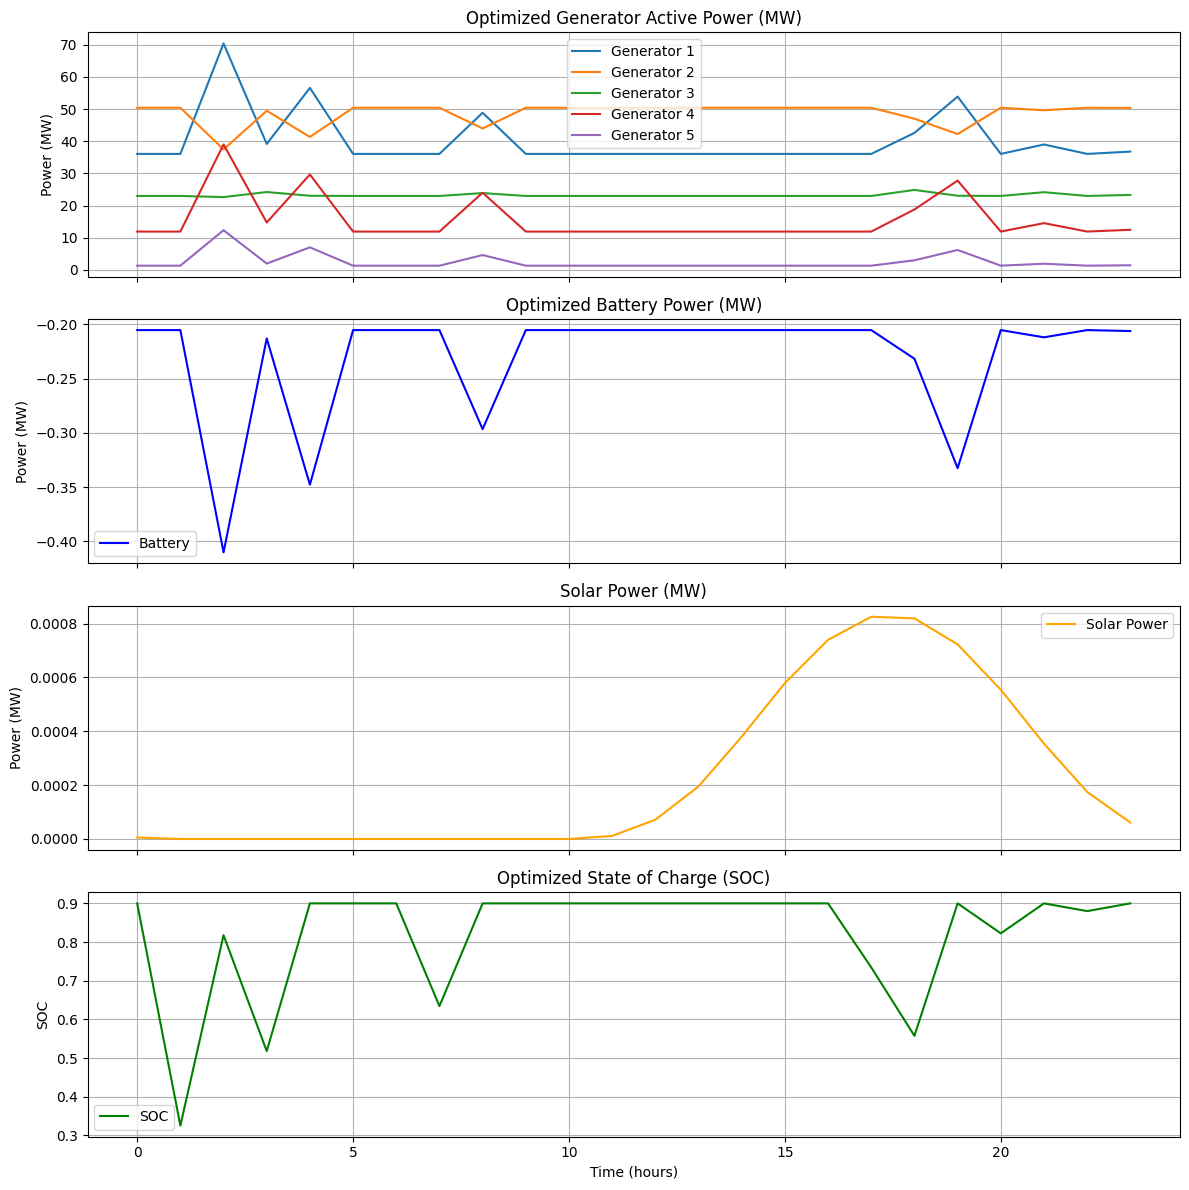

In [6]:
import gym
from gym import spaces
from stable_baselines3 import DDPG
import pandapower as pp
import pandapower.networks as pn
import numpy as np
import numba
import pvlib
import pandas as pd
import matplotlib.pyplot as plt

# Set up the power grid
net = pn.case_ieee30()



# Define Battery
battery_bus = 10
battery_power_mw = 1  # Maximum power in MW
battery_capacity_mwh = 2  # Maximum energy capacity in MWh
pp.create_storage(net, battery_bus, p_mw=0, max_e_mwh=battery_capacity_mwh, max_p_mw=battery_power_mw, name="Battery")

# Define time steps
n_time_steps = 24  # For example, 24 hours

# Define constraints for SOC
SOC_min = 0.1
SOC_max = 0.9

# Initial SOC
initial_SOC = 0.5

# Time step duration in hours
dt = 1

# Define location (latitude and longitude)
location = pvlib.location.Location(latitude=40, longitude=-80)

# Define a time range (for example, 24 hours)
times = pd.date_range(start='2023-08-04', end='2023-08-05', freq='1H')

# Calculate clear-sky GHI and transpose to plane of array
solar_position = location.get_solarposition(times)
clearsky = location.get_clearsky(times, solar_position=solar_position)
dni_extra = pvlib.irradiance.get_extra_radiation(times)  # Calculate extraterrestrial radiation
poa = pvlib.irradiance.get_total_irradiance(
    30, 180, solar_position['apparent_zenith'], solar_position['azimuth'],
    clearsky['dni'], clearsky['ghi'], clearsky['dhi'], dni_extra=dni_extra, model='haydavies'
)

# Define PV system characteristics and ModelChain

inverter_parameters = {
    'paco': 1000,
    'pdc0': 1000,  # Adding pdc0 to inverter parameters
    'eta_inv_nom': 0.96,  # Example of nominal inverter efficiency
}
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
# Continue to define the PVSystem with the updated inverter_parameters
system = pvlib.pvsystem.PVSystem(surface_tilt=30, surface_azimuth=180,
                                 module_parameters={'pdc0': 1000, 'gamma_pdc': -0.004},
                                 inverter_parameters=inverter_parameters,
                                 temperature_model_parameters=temperature_model_parameters)

mc = pvlib.modelchain.ModelChain(system, location, ac_model='pvwatts',
                                 aoi_model='no_loss', spectral_model='no_loss')





# Run model
weather = pd.DataFrame({'temp_air': 25, 'wind_speed': 5}, index=times)
weather['dni'] = poa['poa_direct']
weather['ghi'] = poa['poa_global']
weather['dhi'] = poa['poa_diffuse']
mc.run_model(weather)

# Solar power output in MW


solar_bus = 5
solar_power_mw = mc.results.ac.iloc[0] / 1e6
pp.create_sgen(net, solar_bus, p_mw=solar_power_mw, q_mvar=0, name="Solar Panel")


class GridEnv(gym.Env):


     def __init__(self, net, n_time_steps, initial_SOC, dt):
        super(GridEnv, self).__init__()

        self.net = net
        self.n_time_steps = n_time_steps
        self.SOC = initial_SOC
        self.dt = dt
        self.total_losses = []
        n_gen = len(net.gen)
        # Lower bounds: 0 for generators and -battery_power_mw for battery
        low_bounds = np.concatenate([np.zeros(n_gen), [-battery_power_mw]])
        # Upper bounds: max_p_mw for generators and battery_power_mw for battery
        high_bounds = np.concatenate([net.gen['max_p_mw'].values, [battery_power_mw]])

        self.action_space = spaces.Box(low=low_bounds, high=high_bounds)
        self.observation_space = spaces.Box(low=np.array([SOC_min]), high=np.array([SOC_max]))

        self.reset()




     def step(self, action):
        p_gen = action[:-1]
        p_batt = action[-1]

        self.net.gen['p_mw'] = p_gen
        self.net.storage['p_mw'] = p_batt

        pp.runpp(self.net)

        total_loss = sum(self.net.res_line['pl_mw'])

        c = np.array([0.01, 0.02, 0.03, 0.04, 0.05])  # Replace with your values
        b = np.array([1, 2, 3, 4, 5])  # Replace with your values
        a = np.array([100, 200, 300, 400, 500])  # Replace with your values

        noise_std = 0.7  # Example noise level, you can try different values


        action_with_noise = action + np.random.normal(0, noise_std, action.shape)

        p_gen = action_with_noise[:-1]
        p_batt = action_with_noise[-1]


        # Update SOC with battery power
        self.SOC -= p_batt * self.dt / battery_capacity_mwh

        # Enforce SOC constraints
        if self.SOC < SOC_min:
            self.SOC = SOC_min
        elif self.SOC > SOC_max:
            self.SOC = SOC_max

        # Update p_gen with actual generator outputs
        p_gen_actual = self.net.res_gen['p_mw'].values

        # Calculate total generation cost
        total_cost = np.sum(a + b * p_gen_actual + c * p_gen_actual**2)

        # update solar power
        solar_power_mw = mc.results.ac.iloc[self.current_step] / 1e6
        self.net.sgen.at[0, 'p_mw'] = solar_power_mw



        # Include generation cost in total loss for the reward calculation
        reward = - (total_loss + total_cost)

        self.total_losses.append(total_loss)

        self.current_step += 1
        done = self.current_step == self.n_time_steps

        self.net.gen['p_mw'] = self.net.res_gen['p_mw'].values
        self.net.storage['p_mw'] = self.net.res_storage['p_mw'].values

        return [self.SOC], reward, done, {"total_loss": total_loss, "total_cost": total_cost}



     def reset(self):
        self.net.gen['p_mw'] = 0
        self.net.storage['p_mw'] = 0
        self.current_step = 0
        solar_power_mw = mc.results.ac.iloc[self.current_step] / 1e6
        self.net.sgen.at[0, 'p_mw'] = solar_power_mw
        return [self.SOC]



# Create the environment
env = GridEnv(net, n_time_steps, initial_SOC, dt)

# Create the DDPG agent
model = DDPG('MlpPolicy', env, verbose=1)

# Train the agent
model.learn(total_timesteps=5000)


# Lists to store the results
total_rewards = []
soc_list = []
battery_powers = []

# Lists to store the results
optimized_p_gen = np.zeros((n_time_steps, len(net.gen)))
optimized_p_batt = []
optimized_SOC = []

# Testing the trained model and storing the results in the lists
obs = env.reset()
for t in range(n_time_steps):
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)

    # Storing generator and battery powers
    optimized_p_gen[t, :] = action[:-1]
    optimized_p_batt.append(action[-1])
    optimized_SOC.append(obs[0])

    print(f"Time Step {t+1}")
    print("Total Loss:", info['total_loss'])
    print("Total Cost:", info['total_cost'])
    print("\n")

# Create a figure and axes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Plotting Optimized Generator Active Power
for i in range(len(net.gen)):
    ax1.plot(optimized_p_gen[:, i], label=f"Generator {i+1}")
ax1.set_title('Optimized Generator Active Power (MW)')
ax1.set_ylabel('Power (MW)')
ax1.legend()
ax1.grid(True)

# Plotting Optimized Battery Power
ax2.plot(optimized_p_batt, label="Battery", color='blue')
ax2.set_title('Optimized Battery Power (MW)')
ax2.set_ylabel('Power (MW)')
ax2.legend()
ax2.grid(True)

# Plotting Solar Power
solar_power = [mc.results.ac.iloc[i] / 1e6 for i in range(n_time_steps)]
ax3.plot(solar_power, label="Solar Power", color='orange')
ax3.set_title('Solar Power (MW)')
ax3.set_ylabel('Power (MW)')
ax3.legend()
ax3.grid(True)

# Plotting Optimized SOC
ax4.plot(optimized_SOC, label="SOC", color='green')
ax4.set_title('Optimized State of Charge (SOC)')
ax4.set_xlabel('Time (hours)')
ax4.set_ylabel('SOC')
ax4.legend()
ax4.grid(True)

# Show the plot
plt.tight_layout()
plt.show()





